In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import tensorflow as tf
import keras2.backend.tensorflow_backend as K
import gym2
import copy

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape, s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

def split_params(tw):
    action_tw = []
    tau_tw = []
    for i in range(len(tw)):
        if i % 4 < 2:
            action_tw.append(tw[i])
        else:
            tau_tw.append(tw[i])
    return action_tw, tau_tw

In [4]:
actor = branch_actor((2,),(2,))

In [7]:
# make memory
actor.load_weights('./saved_agent/self_trigger_split.h5')
memory = []
l = 5.
for _ in range(50000):
    env.reset()
    reward = 0
    state0 = env.state
    a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    state1 = env.state
    memory.append([state0, np.array([a_agent, tau]), reward, state1])
memory = np.array(memory)

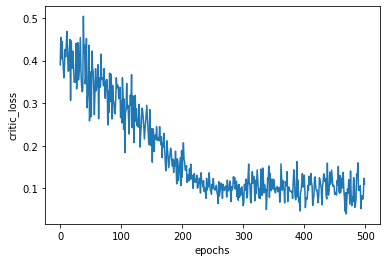

In [8]:
# critic learning
critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
epoch = 500
batch_size = 32
gamma = 0.99
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    r_second = gamma * critic.predict_on_batch(state1_batch_with_action)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

learned_critic = copy.deepcopy(critic)

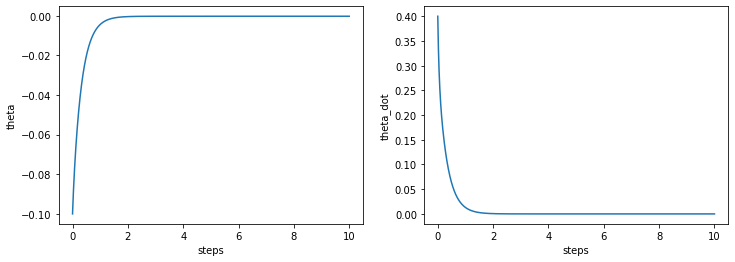

In [9]:
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

env.reset()
env.set_state(np.array([-0.1, 0.4]))
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = actor.predict_on_batch(np.array([[x]]))[0]
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

## check policy gradient for fixed Q function

In [10]:
state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
actor_output = actor(state_input)
combined_input_tensor = [actor_output, state_input]
critic_output_tensor = learned_critic(combined_input_tensor)
loss = -K.mean(critic_output_tensor)
action_tw, tau_tw = split_params(actor.trainable_weights)

In [11]:
from keras2.optimizers import Optimizer

def calculate_gradient(target_func, params, state0_batch, combined_input_tensor):
    dummy_optimizer = Optimizer()
    gradient_tensors = dummy_optimizer.get_gradients(target_func, params)
    
    gradient_calculate_function = _gradient_calculate_function(combined_input_tensor, gradient_tensors)
    gradient_value = gradient_calculate_function([state0_batch])
    
    return gradient_value

def _gradient_calculate_function(combined_input_tensor, gradient_tensors):
    # function input
    input_tensors = [combined_input_tensor[1]]

    # tensorflow running function
    gradient_calculate_function = K.function(input_tensors, gradient_tensors)
    return gradient_calculate_function

def flatten_gradient(gradient_values):
    if len(gradient_values[0].shape) == 2:
        g_array = gradient_values[0].flatten()
    else:
        g_array = gradient_values[0]
    for g in gradient_values[1:]:
        if len(g.shape) == 2:
            g = g.flatten()
        g_array = np.hstack((g_array, g))
    return g_array

In [17]:
# state batch with policy depended distribution

states_batch = []
for i in range(50):
    env.reset()
    time_limit = 3
    acc_time = 0
    while True:
        x = env.state
        states_batch.append([rad_clip(x[0]), x[1]])
        a_agent, tau = actor.predict_on_batch(np.array([[x]]))[0]
        action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        acc_time += tau
        for p in range(action_repetition):
            _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
        if acc_time > time_limit:
            break
    print('\r' + f'{i*2} %', end='')
states_batch = np.array(states_batch)
print()
print(states_batch.shape)

98 %(149281, 2)


In [18]:
state_mini_batch = states_batch[np.random.choice(np.array(range(states_batch.shape[0])), states_batch.shape[0], replace=False)]

In [19]:
# batch gradient

# action_gradient for Q-function
action_gradient = calculate_gradient(loss, action_tw, state_mini_batch, combined_input_tensor)
action_gradient_array = flatten_gradient(action_gradient)
print(action_gradient_array.shape, np.linalg.norm(action_gradient_array))
    
print()
# tau_gradient for Q-function
tau_gradient = calculate_gradient(loss, tau_tw, state_mini_batch, combined_input_tensor)
tau_gradient_array = flatten_gradient(tau_gradient)
print(tau_gradient_array.shape, np.linalg.norm(tau_gradient_array))

(105,) 67.80409

(105,) 1.3254427e-05


In [20]:
# batch gradient

# action_gradient for actor_output
action_gradient_for_action = calculate_gradient(actor_output[:,0], action_tw, state_mini_batch, combined_input_tensor)
action_output_gradient_array = flatten_gradient(action_gradient_for_action)
print(action_output_gradient_array.shape, np.linalg.norm(action_output_gradient_array))
    
print()
# tau_gradient for actor_output
tau_gradient_for_tau = calculate_gradient(actor_output[:,1], tau_tw, state_mini_batch, combined_input_tensor)
tau_output_gradient_array = flatten_gradient(tau_gradient_for_tau)
print(tau_output_gradient_array.shape, np.linalg.norm(tau_output_gradient_array))

(105,) 5543668.5

(105,) 6.619278


In [290]:
def dqda(dqdth, dadth):
    return dqdth/dadth

# ∂Q/∂a
a_gradient_for_q = dqda(action_gradient_array, action_output_gradient_array)
print(a_gradient_for_q)

# ∂Q/∂τ
tau_gradient_for_q = dqda(tau_gradient_array, tau_output_gradient_array)

[ 1.5764630e-06  2.6226626e-06 -2.5523761e-06  2.3081088e-04
  1.0513490e-06  1.1238649e-05  1.2996775e-06 -1.4778662e-05
 -2.5302115e-05  7.8766249e-07 -4.0437799e-06 -4.0520599e-06
 -3.9761908e-06 -1.8488432e-05  7.6846567e-07  7.2460188e-07
 -1.8038792e-06  7.7991029e-07 -4.0320801e-06 -4.1185208e-06
 -3.9887104e-06 -1.9421775e-06  7.7734518e-07  7.1826997e-07
 -1.3899336e-06 -1.4273988e-06 -1.3909518e-06 -1.3917395e-06
 -1.3926106e-06 -1.4084919e-06 -3.4877849e-06            nan
  7.2751016e-07  7.2692080e-07  7.2712635e-07  7.7155022e-07
  7.7236945e-07  7.2674248e-07 -1.5871004e-06            nan
 -3.9564229e-06 -3.9740016e-06 -3.9566958e-06 -3.9575398e-06
 -3.9574747e-06 -3.9581319e-06 -3.9578899e-06            nan
 -4.1685907e-06 -4.1628964e-06 -4.1678545e-06 -4.1649510e-06
 -4.1652993e-06 -4.1628959e-06 -4.1628978e-06            nan
 -3.3614672e-06 -3.4931622e-06 -3.3614679e-06 -3.3614683e-06
 -3.3614688e-06 -3.3935382e-06 -3.3889960e-06            nan
 -3.7517982e-06 -3.75172